In [111]:
import matplotlib.pyplot as plt
import json
from functional import seq
import itertools
import subprocess
import collections
import os.path
from ipywidgets import widgets
from IPython.display import display

try: 
    from ipywidgets import widgets
    from progressbar import log_progress
    IPYWIDGETS = True
except ModuleNotFoundError:
    log_progress = lambda x: x
    IPYWIDGETS = False

In [5]:
def read(path):
    with open(path, "r") as f:
        inp = f.read()
    inp = inp.replace("}\n{", "},\n{")
    inp = "[" + inp + "]"
    a = json.loads(inp)
    return a

In [53]:
def call(p, randomized_hashes):
    return ("java", "-classpath", ".:lib/commons-cli-1.4.jar", "KMeans", 
            "-testdata", "LSH-nmi-adapted.csv", 
            "-p", str(p),
            "-r", str(randomized_hashes).lower())

In [69]:
def run_tries(tries=1, ps=(0,1,2,3,4,5,6,7,8,9,10), rs=(False, True)):
    if not isinstance(ps, collections.Iterable):
        ps = [ps]
    if not isinstance(rs, collections.Iterable):
        rs = [rs]
    product = list(itertools.product(ps, rs, range(tries)))
    for p, r, _ in log_progress(product, every=1):
        process = subprocess.run(call(p, r), stdout=subprocess.PIPE)
        with open("output.raw", mode="ab") as f:
            f.write(process.stdout)

In [50]:
def boxplot(data, x, y):
    grouped = seq(data).group_by(lambda data: data[x]).sorted(lambda x: x[0])
    x_data = grouped.map(lambda data: data[0])
    y_data = grouped.map(lambda data: [line[y] for line in data[1]])
    #plt.plot(list(x_data), list(y_data))
    plt.boxplot(list(y_data))
    plt.xticks(list(range(len(list(y_data)))), list(x_data))

    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

In [85]:
def line(data, x, y):
    grouped = seq(data).group_by(lambda data: data[x]).sorted(lambda x: x[0])
    x_data = grouped.map(lambda data: data[0])
    y_data = grouped.map(lambda data: sum([line[y] for line in data[1]]) / len(data[1]))
    plt.plot(list(x_data), list(y_data))
    plt.plot(list(x_data), list(y_data), "o")

    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

In [168]:
if not os.path.isfile("output.raw"):
    if IPYWIDGETS:
        label = widgets.HTML("Couldn't find output, please gather some.")
        display(label)
    else:
        print("Couldn't find output. I'm now generating data, this might take a long time.")
else:
    if IPYWIDGETS:
        label = widgets.HTML("Data already found! You don't need to gather data to carry on.")
        display(label)
    else:
        print("Found data, carry on with analysis.")
    
if IPYWIDGETS:
    layouts = []
    default_layout = widgets.Layout()
    layouts.append(default_layout)
    
    button_layout = widgets.Layout(margin="20px 40% 20px 40%", padding="20px auto 20px auto", height="50px")
    layouts.append(button_layout)
    button = widgets.Button(description="Gather Data", layout=button_layout, button_style="danger")
    random_hashes_widget = widgets.ToggleButtons(options=["Random Hashes","Canonical Projections", "Both"],
                                                      value="Both", layout=default_layout)

    ps_widget_layout = widgets.Layout(width="100%")
    layouts.append(ps_widget_layout)
    ps_widget = widgets.IntRangeSlider(value=[0,10], min=0, max=10, step=1, 
                                       layout=ps_widget_layout, description="Parameter P for similarity")
    
    display(random_hashes_widget)
    display(ps_widget)
    
    display(button)
    def on_click(_):
        if random_hashes_widget.value == "Both":
            rs = [True, False]
        elif random_hashes_widget.value == "Random Hashes":
            rs = [True]
        elif random_hashes_widget.value == "Canonical Projections":
            rs = [False]
        for l in layouts:
            l.display = "none"
        run_tries(rs=rs, ps=ps_widget.value)
        for l in layouts:
            l.display = None
    button.on_click(on_click)
else:
    if not (os.path.isfile("output.raw")):
        run_tries()

In [153]:
layouts[0].display = None

In [125]:
random_hashes_widget.value

'Both'

In [109]:

#output = read("output.raw")

with open("output.raw", "r") as f:
    inp = f.read()
inp = inp.replace("false", "")
inp = inp.replace("true", "")
inp = inp.replace("\n\n", "\n")
inp = inp.replace("}\n{", "},\n{")
inp = "[" + inp + "]"
output = json.loads(inp)


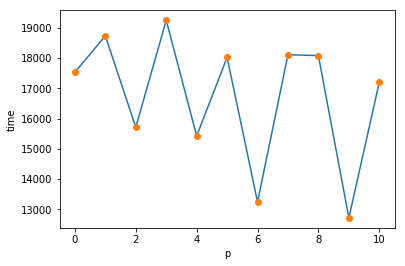

In [100]:
line(output, "p", "time")

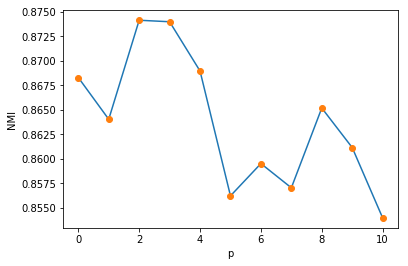

In [99]:
line(output, "p", "NMI")